In [1]:
# 1. SETUP AND LIBRARY IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Scikit-learn imports
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# SciPy for hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import stats

# Display options
pd.set_option("display.precision", 3)
np.set_printoptions(precision=5, suppress=True)
pd.options.display.float_format = '{:.4f}'.format
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
# 2. DATA LOADING AND PREPROCESSING

# Load data
df = pd.read_csv('/content/data.csv')
print(f"\nDataset loaded: {df.shape[0]} vehicles, {df.shape[1]} features")

# Clean column names and remove index if present
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)
df.columns = df.columns.str.strip()
df['Brand'] = df['Brand'].str.strip()

# Store metadata for later use
metadata = df[['Brand', 'Model']].copy()

# Separate features for analysis
numerical_features = ['AccelSec', 'TopSpeed_KmH', 'Range_Km', 'Efficiency_WhKm',
                     'FastCharge_KmH', 'Seats', 'PriceEuro']
categorical_features = ['RapidCharge', 'PowerTrain', 'PlugType', 'BodyStyle', 'Segment']

print(f"\nNumerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Convert Yes/No to 1/0
df['RapidCharge'] = df['RapidCharge'].map({'Yes': 1, 'No': 0})

# One-hot encoding for categorical variables
df_encoded = pd.get_dummies(df.drop(columns=['Brand', 'Model']),
                           columns=['PowerTrain', 'PlugType', 'BodyStyle', 'Segment'],
                           drop_first=True)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)
feature_names = df_encoded.columns.tolist()

print(f"\nFeatures after preprocessing: {X_scaled.shape[1]}")


Dataset loaded: 103 vehicles, 15 features

Numerical features: 7
Categorical features: 5

Features after preprocessing: 28


/tmp/ipython-input-1877435067.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax6.boxplot(powertrain_data, labels=df['PowerTrain'].unique(), patch_artist=True)


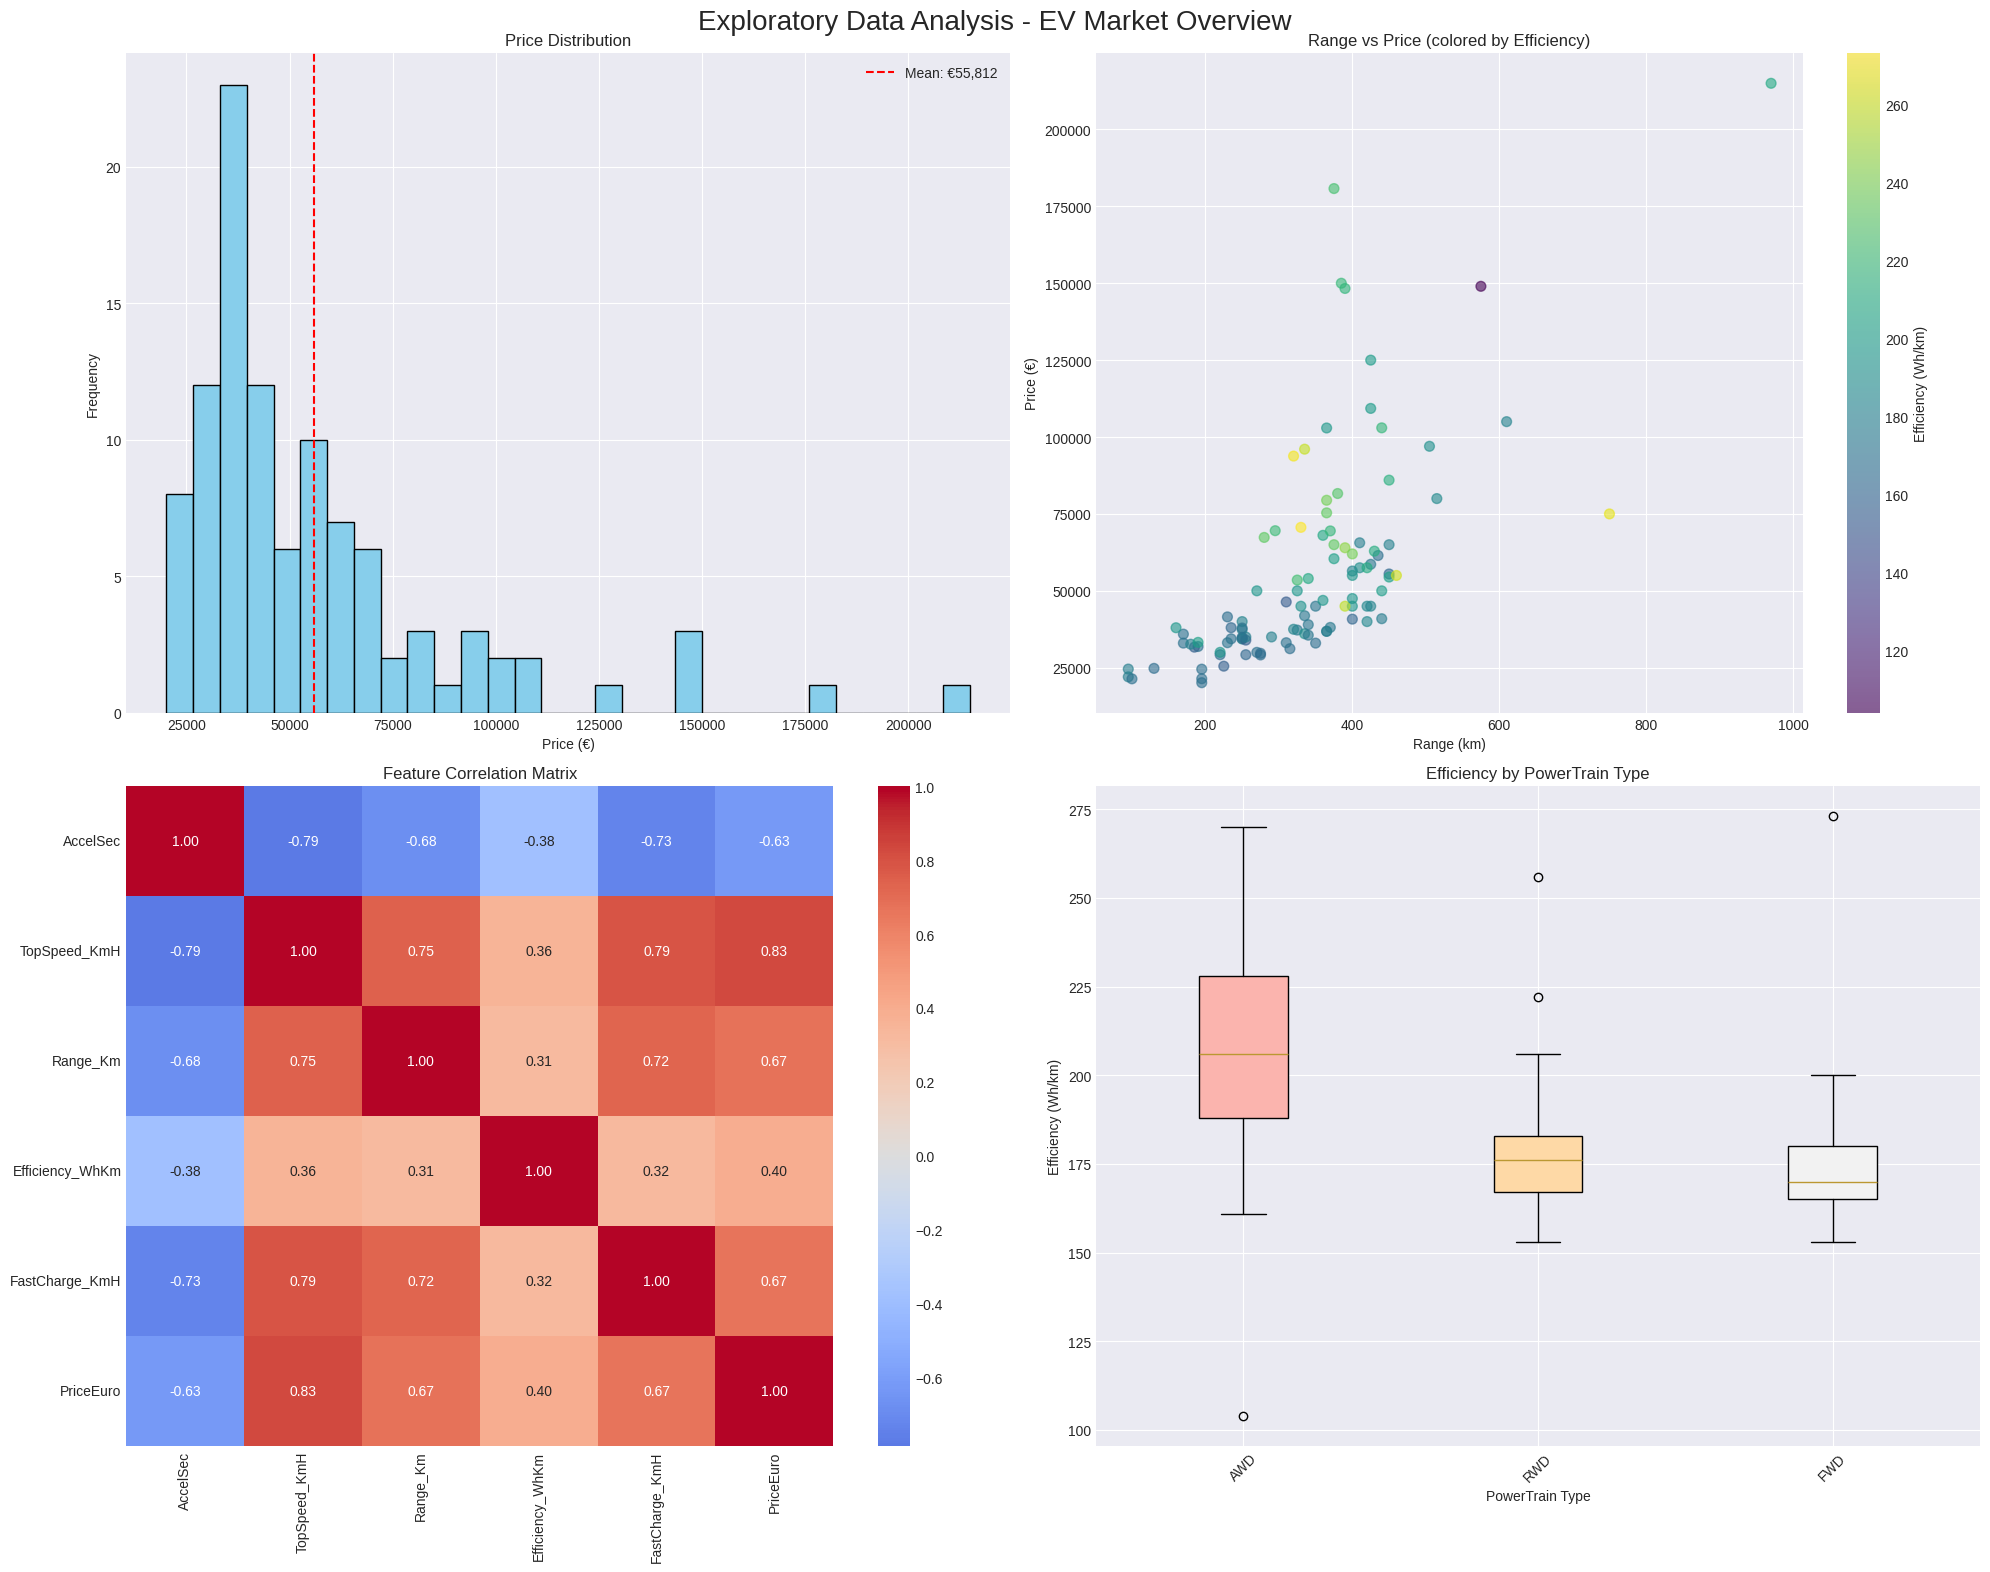

In [3]:
# 3. EXPLORATORY DATA ANALYSIS (EDA)

# Create comprehensive EDA visualization
fig = plt.figure(figsize=(20, 16))

# 1. Price Distribution
ax1 = plt.subplot(2, 2, 1)
df['PriceEuro'].hist(bins=30, ax=ax1, color='skyblue', edgecolor='black')
ax1.axvline(df['PriceEuro'].mean(), color='red', linestyle='--', label=f'Mean: €{df["PriceEuro"].mean():,.0f}')
ax1.set_xlabel('Price (€)')
ax1.set_ylabel('Frequency')
ax1.set_title('Price Distribution')
ax1.legend()

# 2. Range vs Price Scatter
ax2 = plt.subplot(2, 2, 2)
scatter = ax2.scatter(df['Range_Km'], df['PriceEuro'],
                     c=df['Efficiency_WhKm'], cmap='viridis', alpha=0.6, s=50)
ax2.set_xlabel('Range (km)')
ax2.set_ylabel('Price (€)')
ax2.set_title('Range vs Price (colored by Efficiency)')
plt.colorbar(scatter, ax=ax2, label='Efficiency (Wh/km)')

# 3. Performance Metrics Correlation
ax4 = plt.subplot(2, 2, 3)
perf_cols = ['AccelSec', 'TopSpeed_KmH', 'Range_Km', 'Efficiency_WhKm', 'FastCharge_KmH', 'PriceEuro']
corr_matrix = df[perf_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax4)
ax4.set_title('Feature Correlation Matrix')

# 4. Efficiency by PowerTrain
ax6 = plt.subplot(2, 2, 4)
powertrain_data = [df[df['PowerTrain'] == pt]['Efficiency_WhKm'].values
                   for pt in df['PowerTrain'].unique()]
bp = ax6.boxplot(powertrain_data, labels=df['PowerTrain'].unique(), patch_artist=True)
for patch, color in zip(bp['boxes'], plt.cm.Pastel1(np.linspace(0, 1, len(bp['boxes'])))):
    patch.set_facecolor(color)
ax6.set_xlabel('PowerTrain Type')
ax6.set_ylabel('Efficiency (Wh/km)')
ax6.set_title('Efficiency by PowerTrain Type')
ax6.tick_params(axis='x', rotation=45)

plt.suptitle('Exploratory Data Analysis - EV Market Overview', fontsize=20)
plt.tight_layout()
plt.show()


Variance explained:
   - 85% variance: 12 components
   - 90% variance: 14 components
   - 95% variance: 16 components


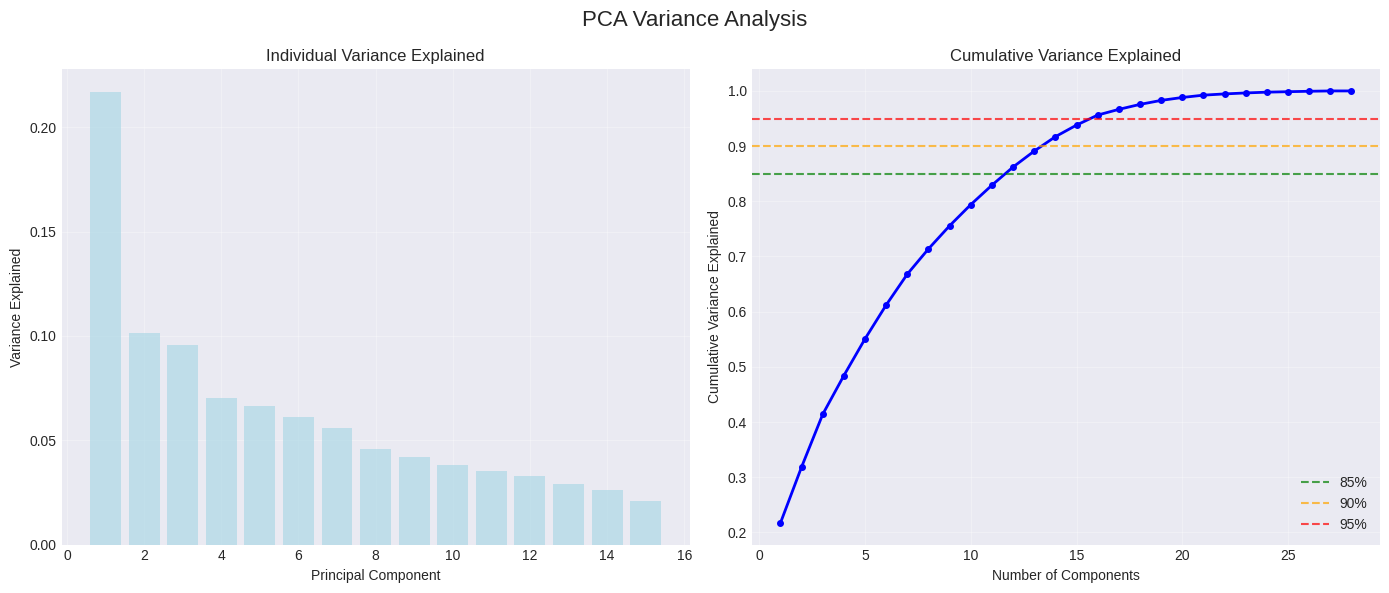


Selected 14 components explaining 91.7% of variance


In [4]:
# 4. PRINCIPAL COMPONENT ANALYSIS (PCA)

# Perform PCA
pca = PCA()
X_pca_full = pca.fit_transform(X_scaled)

# Calculate variance explained
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Find optimal number of components (95% variance)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_85 = np.argmax(cumulative_variance >= 0.85) + 1

print(f"\nVariance explained:")
print(f"   - 85% variance: {n_components_85} components")
print(f"   - 90% variance: {n_components_90} components")
print(f"   - 95% variance: {n_components_95} components")

# Create variance plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Individual variance
ax1.bar(range(1, 16), explained_variance[:15], alpha=0.7, color='lightblue')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Variance Explained')
ax1.set_title('Individual Variance Explained')
ax1.grid(True, alpha=0.3)

# Cumulative variance
ax2.plot(range(1, len(cumulative_variance)+1), cumulative_variance,
         'bo-', linewidth=2, markersize=4)
ax2.axhline(y=0.85, color='green', linestyle='--', alpha=0.7, label='85%')
ax2.axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90%')
ax2.axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95%')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Variance Explained')
ax2.set_title('Cumulative Variance Explained')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('PCA Variance Analysis', fontsize=16)
plt.tight_layout()
plt.show()

# Select components for 90% variance
n_components = n_components_90
X_pca = X_pca_full[:, :n_components]
print(f"\nSelected {n_components} components explaining {cumulative_variance[n_components-1]:.1%} of variance")

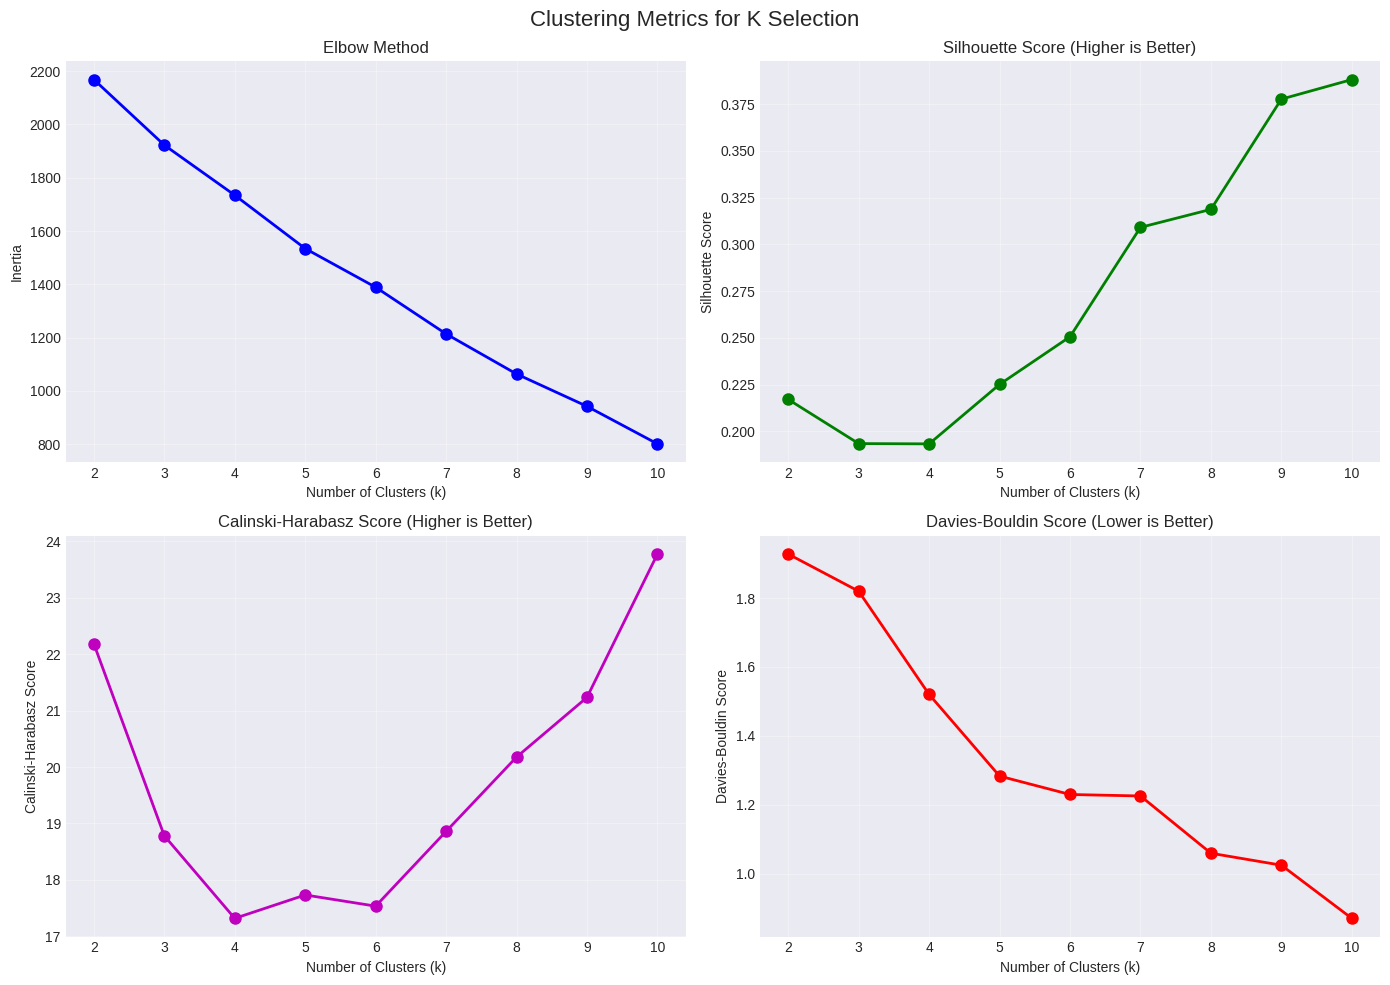


Optimal number of clusters: 10


In [5]:
# 5. OPTIMAL CLUSTER NUMBER DETERMINATION

# Test range of clusters
k_range = range(2, 11)
metrics = {
    'k': [],
    'inertia': [],
    'silhouette': [],
    'calinski': [],
    'davies_bouldin': []
}

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_pca)

    metrics['k'].append(k)
    metrics['inertia'].append(kmeans.inertia_)
    metrics['silhouette'].append(silhouette_score(X_pca, labels))
    metrics['calinski'].append(calinski_harabasz_score(X_pca, labels))
    metrics['davies_bouldin'].append(davies_bouldin_score(X_pca, labels))

# Create evaluation plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Elbow plot
ax1.plot(metrics['k'], metrics['inertia'], 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')
ax1.grid(True, alpha=0.3)

# Silhouette score
ax2.plot(metrics['k'], metrics['silhouette'], 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score (Higher is Better)')
ax2.grid(True, alpha=0.3)

# Calinski-Harabasz score
ax3.plot(metrics['k'], metrics['calinski'], 'mo-', linewidth=2, markersize=8)
ax3.set_xlabel('Number of Clusters (k)')
ax3.set_ylabel('Calinski-Harabasz Score')
ax3.set_title('Calinski-Harabasz Score (Higher is Better)')
ax3.grid(True, alpha=0.3)

# Davies-Bouldin score
ax4.plot(metrics['k'], metrics['davies_bouldin'], 'ro-', linewidth=2, markersize=8)
ax4.set_xlabel('Number of Clusters (k)')
ax4.set_ylabel('Davies-Bouldin Score')
ax4.set_title('Davies-Bouldin Score (Lower is Better)')
ax4.grid(True, alpha=0.3)

plt.suptitle('Clustering Metrics for K Selection', fontsize=16)
plt.tight_layout()
plt.show()

# Select optimal k based on multiple metrics
silhouette_norm = (metrics['silhouette'] - np.min(metrics['silhouette'])) / (np.max(metrics['silhouette']) - np.min(metrics['silhouette']))
calinski_norm = (metrics['calinski'] - np.min(metrics['calinski'])) / (np.max(metrics['calinski']) - np.min(metrics['calinski']))
davies_norm = 1 - (metrics['davies_bouldin'] - np.min(metrics['davies_bouldin'])) / (np.max(metrics['davies_bouldin']) - np.min(metrics['davies_bouldin']))

# Combined score
combined_scores = [(s + c + d) / 3 for s, c, d in zip(silhouette_norm, calinski_norm, davies_norm)]
optimal_k = metrics['k'][np.argmax(combined_scores)]

print(f"\nOptimal number of clusters: {optimal_k}")

In [6]:
# 6. COMPARATIVE CLUSTERING ANALYSIS

# Initialize models
models = {
    'K-Means': KMeans(n_clusters=optimal_k, init='k-means++', n_init=10, random_state=42),
    'Hierarchical': AgglomerativeClustering(n_clusters=optimal_k, linkage='ward'),
    'GMM': GaussianMixture(n_components=optimal_k, random_state=42)
}

# Fit models and evaluate
results = []
cluster_labels = {}

for name, model in models.items():
    if name == 'GMM':
        model.fit(X_pca)
        labels = model.predict(X_pca)
    else:
        labels = model.fit_predict(X_pca)

    cluster_labels[name] = labels

    # Calculate metrics
    sil_score = silhouette_score(X_pca, labels)
    cal_score = calinski_harabasz_score(X_pca, labels)
    db_score = davies_bouldin_score(X_pca, labels)

    results.append({
        'Algorithm': name,
        'Silhouette': sil_score,
        'Calinski-Harabasz': cal_score,
        'Davies-Bouldin': db_score
    })

    print(f"\n{name}:")
    print(f"  Silhouette Score: {sil_score:.4f}")
    print(f"  Calinski-Harabasz: {cal_score:.4f}")
    print(f"  Davies-Bouldin: {db_score:.4f}")

# Create comparison dataframe
results_df = pd.DataFrame(results)

# Normalize scores for comparison
results_df['Silhouette_norm'] = (results_df['Silhouette'] - results_df['Silhouette'].min()) / (results_df['Silhouette'].max() - results_df['Silhouette'].min())
results_df['Calinski_norm'] = (results_df['Calinski-Harabasz'] - results_df['Calinski-Harabasz'].min()) / (results_df['Calinski-Harabasz'].max() - results_df['Calinski-Harabasz'].min())
results_df['Davies_norm'] = 1 - (results_df['Davies-Bouldin'] - results_df['Davies-Bouldin'].min()) / (results_df['Davies-Bouldin'].max() - results_df['Davies-Bouldin'].min())
results_df['Overall_Score'] = (results_df['Silhouette_norm'] + results_df['Calinski_norm'] + results_df['Davies_norm']) / 3

# Select best model
best_model = results_df.loc[results_df['Overall_Score'].idxmax(), 'Algorithm']
best_labels = cluster_labels[best_model]

print(f"\nBest performing model: {best_model}")
print("\nModel Comparison Summary:")
print(results_df[['Algorithm', 'Overall_Score']].sort_values('Overall_Score', ascending=False))



K-Means:
  Silhouette Score: 0.3882
  Calinski-Harabasz: 23.7736
  Davies-Bouldin: 0.8705

Hierarchical:
  Silhouette Score: 0.3824
  Calinski-Harabasz: 22.9728
  Davies-Bouldin: 0.9282

GMM:
  Silhouette Score: 0.3882
  Calinski-Harabasz: 23.7736
  Davies-Bouldin: 0.8705

Best performing model: K-Means

Model Comparison Summary:
      Algorithm  Overall_Score
0       K-Means         1.0000
2           GMM         1.0000
1  Hierarchical         0.0000


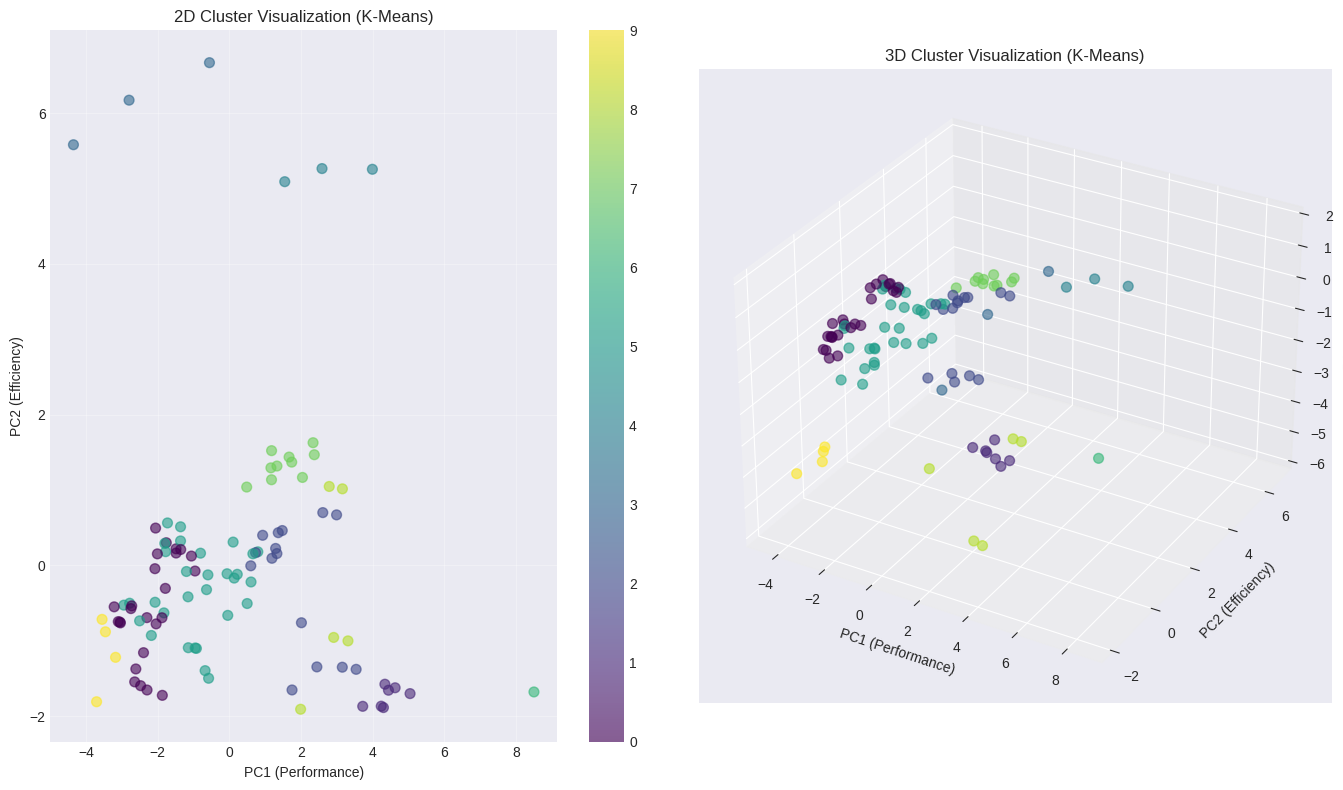

In [7]:
# 7. CLUSTERING VISUALIZATION

# Add cluster labels and PCA components to dataframe
df['Cluster'] = best_labels
df['PC1'] = X_pca_full[:, 0]
df['PC2'] = X_pca_full[:, 1]
df['PC3'] = X_pca_full[:, 2] if X_pca_full.shape[1] > 2 else 0

# Create 2D and 3D visualizations
fig = plt.figure(figsize=(20, 8))

# 2D visualization
ax1 = fig.add_subplot(131)
scatter1 = ax1.scatter(df['PC1'], df['PC2'], c=df['Cluster'],
                      cmap='viridis', alpha=0.6, s=50)
ax1.set_xlabel('PC1 (Performance)')
ax1.set_ylabel('PC2 (Efficiency)')
ax1.set_title(f'2D Cluster Visualization ({best_model})')
plt.colorbar(scatter1, ax=ax1)
ax1.grid(True, alpha=0.3)

# 3D visualization
ax2 = fig.add_subplot(132, projection='3d')
scatter2 = ax2.scatter(df['PC1'], df['PC2'], df['PC3'],
                      c=df['Cluster'], cmap='viridis', alpha=0.6, s=50)
ax2.set_xlabel('PC1 (Performance)')
ax2.set_ylabel('PC2 (Efficiency)')
ax2.set_zlabel('PC3 (Utility)')
ax2.set_title(f'3D Cluster Visualization ({best_model})')

plt.tight_layout()
plt.show()

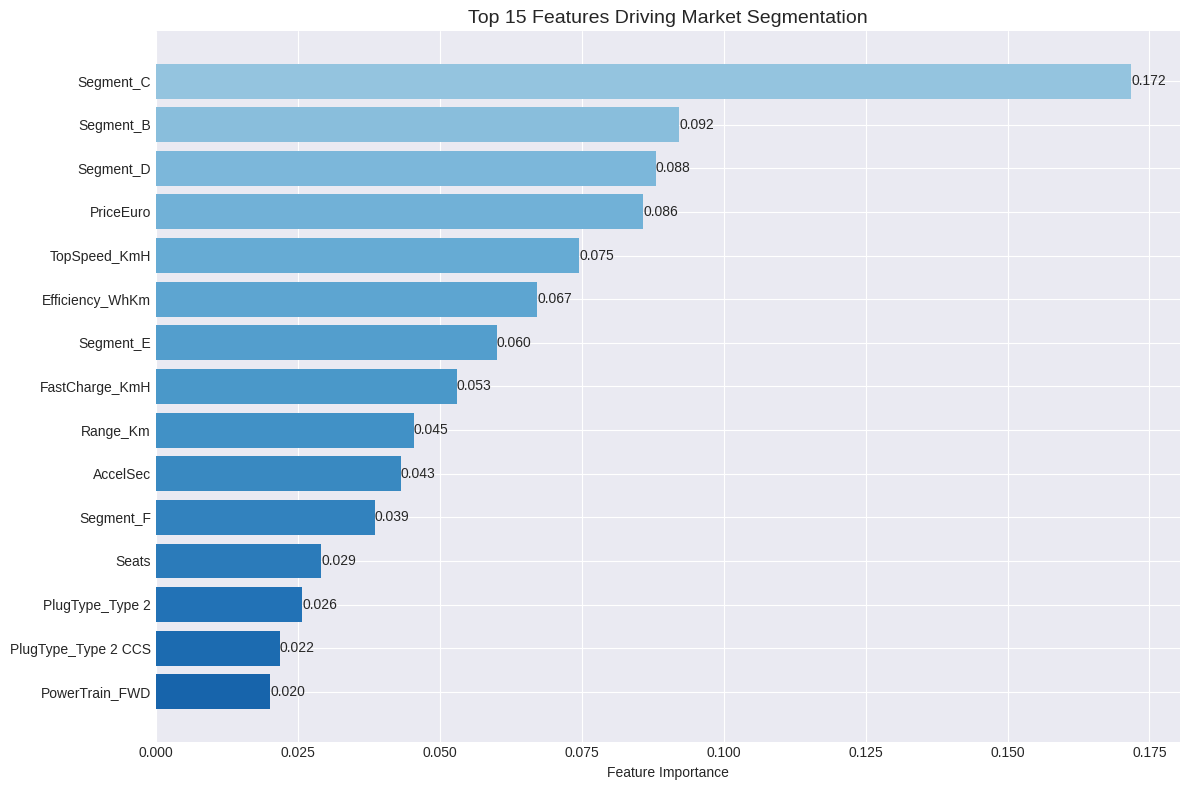


Top 10 Most Important Features:
            Feature  Importance
22        Segment_C      0.1718
21        Segment_B      0.0922
23        Segment_D      0.0880
7         PriceEuro      0.0859
1      TopSpeed_KmH      0.0745
3   Efficiency_WhKm      0.0672
24        Segment_E      0.0601
4    FastCharge_KmH      0.0530
2          Range_Km      0.0455
0          AccelSec      0.0432


In [8]:
# 8. FEATURE IMPORTANCE ANALYSIS

# Train Random Forest on original features to predict clusters
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_scaled, best_labels)

# Get feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Create importance plot
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
bars = plt.barh(range(len(top_features)), top_features['Importance'],
                color=plt.cm.Blues(np.linspace(0.4, 0.8, len(top_features))))
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Features Driving Market Segmentation', fontsize=14)
plt.gca().invert_yaxis()

# Add value labels on bars
for i, (idx, row) in enumerate(top_features.iterrows()):
    plt.text(row['Importance'], i, f'{row["Importance"]:.3f}',
             va='center', ha='left', fontsize=10)

plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

In [9]:
# 9. DETAILED SEGMENT PROFILING

# Profile each segment
segment_profiles = []
for cluster in sorted(df['Cluster'].unique()):
    cluster_data = df[df['Cluster'] == cluster]
    n_vehicles = len(cluster_data)

    print(f"\n{'='*50}")
    print(f"CLUSTER {cluster} - {n_vehicles} vehicles ({n_vehicles/len(df)*100:.1f}%)")
    print(f"{'='*50}")

    # Price analysis
    price_stats = cluster_data['PriceEuro'].describe()
    print(f"\nPrice Profile:")
    print(f"   Average: €{price_stats['mean']:,.0f}")
    print(f"   Range: €{price_stats['min']:,.0f} - €{price_stats['max']:,.0f}")

    # Performance analysis
    print(f"\nPerformance Profile:")
    print(f"   Acceleration: {cluster_data['AccelSec'].mean():.1f}s (0-100km/h)")
    print(f"   Top Speed: {cluster_data['TopSpeed_KmH'].mean():.0f} km/h")

    # Range and efficiency
    print(f"\nRange & Efficiency:")
    print(f"   Range: {cluster_data['Range_Km'].mean():.0f} km")
    print(f"   Efficiency: {cluster_data['Efficiency_WhKm'].mean():.0f} Wh/km")
    print(f"   Fast Charge: {cluster_data['FastCharge_KmH'].mean():.0f} km/h")

    # Top brands
    print(f"\nTop Brands:")
    top_brands = cluster_data['Brand'].value_counts().head(5)
    for brand, count in top_brands.items():
        print(f"   - {brand}: {count} models ({count/n_vehicles*100:.0f}%)")



CLUSTER 0 - 25 vehicles (24.3%)

Price Profile:
   Average: €33,267
   Range: €20,129 - €41,906

Performance Profile:
   Acceleration: 9.1s (0-100km/h)
   Top Speed: 148 km/h

Range & Efficiency:
   Range: 257 km
   Efficiency: 168 Wh/km
   Fast Charge: 278 km/h

Top Brands:
   - Renault: 3 models (12%)
   - Opel: 3 models (12%)
   - Kia: 3 models (12%)
   - Hyundai: 2 models (8%)
   - Honda: 2 models (8%)

CLUSTER 1 - 7 vehicles (6.8%)

Price Profile:
   Average: €131,618
   Range: €102,945 - €180,781

Performance Profile:
   Acceleration: 3.4s (0-100km/h)
   Top Speed: 251 km/h

Range & Efficiency:
   Range: 425 km
   Efficiency: 203 Wh/km
   Fast Charge: 779 km/h

Top Brands:
   - Porsche: 5 models (71%)
   - Lucid: 1 models (14%)
   - Audi: 1 models (14%)

CLUSTER 2 - 15 vehicles (14.6%)

Price Profile:
   Average: €58,488
   Range: €46,380 - €69,484

Performance Profile:
   Acceleration: 5.4s (0-100km/h)
   Top Speed: 202 km/h

Range & Efficiency:
   Range: 400 km
   Efficiency: 

In [10]:
# 10. EXPORT RESULTS

# Save segmented data
df_export = df.copy()
df_export = df_export[['Brand', 'Model', 'Cluster'] + numerical_features + categorical_features]
df_export.to_csv('ev_segments_enhanced.csv', index=False)
print("Segmented data saved to 'ev_segments_enhanced.csv'")

# Save segment summary
segment_summary = []
for cluster in sorted(df['Cluster'].unique()):
    cluster_data = df[df['Cluster'] == cluster]
    summary = {
        'Cluster': cluster,
        'Size': len(cluster_data),
        'Percentage': f"{len(cluster_data)/len(df)*100:.1f}%",
        'Avg_Price': f"€{cluster_data['PriceEuro'].mean():,.0f}",
        'Avg_Range': f"{cluster_data['Range_Km'].mean():.0f} km",
        'Avg_Acceleration': f"{cluster_data['AccelSec'].mean():.1f}s",
        'Top_Brands': ', '.join(cluster_data['Brand'].value_counts().head(3).index)
    }
    segment_summary.append(summary)

segment_summary_df = pd.DataFrame(segment_summary)
segment_summary_df.to_csv('segment_summary.csv', index=False)
print("Segment summary saved to 'segment_summary.csv'")

# Save model comparison
results_df[['Algorithm', 'Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin', 'Overall_Score']].to_csv('model_comparison_enhanced.csv', index=False)
print("Model comparison saved to 'model_comparison_enhanced.csv'")

# Save feature importance
importance_df.to_csv('feature_importance_enhanced.csv', index=False)
print("Feature importance saved to 'feature_importance_enhanced.csv'")


Segmented data saved to 'ev_segments_enhanced.csv'
Segment summary saved to 'segment_summary.csv'
Model comparison saved to 'model_comparison_enhanced.csv'
Feature importance saved to 'feature_importance_enhanced.csv'
